In [292]:
import matplotlib as mpl
from numpy import dtype

from ecoli.variants.new_gene_internal_shift import get_new_gene_ids_and_indices
from wholecell.utils.modular_fba import solver

mpl.rcParams['figure.dpi'] = 150

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import polars as pl
import itertools
import warnings
from scipy.sparse import csr_matrix
from scipy import stats
import scipy.ndimage as ndimage
from textwrap import wrap

import cvxpy as cp

import pandas as pd
import statsmodels.api as sm 

sns.set_style("darkgrid")
sns.set_palette("Set2")
sns.set_context("paper")
warnings.filterwarnings(action='ignore')

RELOAD_ACCESSION_DATA = False

In [293]:
def read_names(file_path):
    return np.genfromtxt(file_path, dtype=str, delimiter="\n")

complex_ids = read_names("data/complex_ids.txt")
monomer_ids = read_names("data/protein_ids.txt")
cofactor_ids = read_names("data/cofactor_ids.txt")
element_ids = read_names("data/element_ids.txt")
protein_ids = complex_ids.tolist() + monomer_ids.tolist()

# Reading the matrix CSV files
def read_matrix(file_path, sparse=False):
    # add sparse matrix reading
    if sparse:
        return csr_matrix(pl.read_csv(file_path, has_header=False).to_numpy())
    else:
        return pl.read_csv(file_path, has_header=False).to_numpy()

C = read_matrix("data/C_matrix.csv", sparse=True)
P = read_matrix("data/P_matrix.csv", sparse=True)
E = read_matrix("data/E_matrix.csv", sparse=True)
Tree = read_matrix("data/tree_matrix.csv", sparse=True)
tree_ids = complex_ids.tolist() + monomer_ids.tolist() + cofactor_ids.tolist()

total_counts_min = read_matrix("data/counts.csv")

element_isotope_mapping = {"MN": "55Mn", "CU": "63Cu", "MO": "95Mo", "NI": "60Ni", "FE": "56Fe", "ZN": "66Zn"}
# reverse mapping
isotope_element_mapping = {v: k for k, v in element_isotope_mapping.items()}

## import conversion table

In [294]:
conversion_df = pl.read_csv("external_data/metalloproteome_exp_conversion.csv")

# get all unique values of End and Index
end_values = conversion_df["End"].unique().to_list()
index_values = conversion_df["Index"].unique().to_list()

# give each unique value a unique number
end_dict = {end: i for i, end in enumerate(end_values)}
index_dict = {index: i for i, index in enumerate(index_values)}

# create a new column for the unique value
conversion_df = conversion_df.with_columns(x=pl.col("End").replace(end_dict))
conversion_df = conversion_df.with_columns(y=pl.col("Index").replace(index_dict))

# drop start end index
conversion_df = conversion_df.drop(["Start", "End", "Index"])

conversion_df

Experiment,x,y
str,i64,i64
"""0to0_1""",0,0
"""0to0_2""",0,1
"""0to0_3""",0,2
"""0to0_4""",0,3
"""0to0_5""",0,4
…,…,…
"""900to1000_28""",17,27
"""900to1000_29""",17,28
"""900to1000_30""",17,29



## Import protein data

In [295]:
import requests
import xml.etree.ElementTree as ET
import time

if RELOAD_ACCESSION_DATA:
    for accession_id in prot_df["Accession Number"]:
        
        if accession_id not in gene_dict:
            # add a 0.1 second delay between each request
            time.sleep(1)
            
            # Step 1: Use elink to find the Gene ID associated with the protein accession
            elink_url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/elink.fcgi?dbfrom=protein&db=gene&id={accession_id}&retmode=xml"
            elink_response = requests.get(elink_url)
            elink_tree = ET.fromstring(elink_response.content)
            
            # Extract the Gene ID from the elink response
            gene_id = None
            for linkset in elink_tree.findall(".//LinkSetDb"):
                if linkset.find("LinkName").text == "protein_gene" and linkset.find(".//Id") is not None:
                    gene_id = linkset.find(".//Id").text
                    break
            
            # Step 2: Use esummary to get the gene information based on the Gene ID
            if gene_id:
                esummary_url = f"https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi?db=gene&id={gene_id}&retmode=xml"
                esummary_response = requests.get(esummary_url, headers=headers)
                esummary_tree = ET.fromstring(esummary_response.content)
                
                # Extract the gene name
                gene_name = esummary_tree.find(".//Name").text
                print(f"Gene name: {gene_name}")
            else:
                print("Gene ID not found.")
                
            gene_dict[accession_id] = gene_name

In [296]:
# load gene df
gene_df = pl.read_csv("data/accession_gene_dict.csv")
gene_df

# convert to dict
gene_dict = dict(zip(gene_df["Accession Number"], gene_df["Gene Name"]))

gene_df

Accession Number,Gene Name
str,str
"""AAC76954.1""","""tufB"""
"""AAC76345.1""","""rplC"""
"""AAC76328.1""","""rpsE"""
"""AAC74990.1""","""fliC"""
"""AAC77103.1""","""groL"""
…,…
"""AAC75718.1""","""ygaC"""
"""AAC73987.1""","""ycaK"""
"""AAC77128.1""","""miaA"""


## Change column to gene name

In [297]:
# Load the data
prot_df_raw = pl.read_csv('external_data/metalloproteome_proteins.csv')

# drop "#", "Visible?", "Starred?", "Molecular Weight"
prot_df = prot_df_raw.drop(["#", "Visible?", "Starred?", "Molecular Weight", "Taxonomy"])

prot_df.head(5)

# change column to gene name
prot_df = prot_df.with_columns(Gene=pl.col("Accession Number").replace(gene_dict))

# drop Identified Proteins (1235), Accession Number
prot_df = prot_df.drop(["Identified Proteins (1235)", "Accession Number"])

# drop duplicate rows with the same gene name
prot_df = prot_df.unique(subset=["Gene"], maintain_order=True)

# transpose and keep gene as column names
prot_exp_names = list(prot_df.columns)[:-1]
gene_names = prot_df["Gene"].to_list()

In [298]:
# transpose and keep gene as column names
prot_df = prot_df.drop(["Gene"]).transpose()
prot_df.columns = gene_names

# add a new column, "Experiment"
prot_df = prot_df.with_columns(pl.Series(name="Experiment", values=prot_exp_names))

# join with the conversion table
prot_df = prot_df.join(conversion_df, on="Experiment")

prot_df

tufB,rplC,rpsE,fliC,groL,rpsT,rplD,rplX,rplR,rpsL,rplO,rplM,rpsA,rplV,icd,ilvC,rpsG,rpsN,rplN,rplB,rpsU,rplA,rplU,rpmB,carB,metE,eno,fusA,rpoB,rpoC,rpsI,hupA,rpsS,gapA,dppA,rpmD,oppA,…,tdh,hemN,chaB,yjhU,putA,hemF,efeB,paaY,yciG,yidC,dnaQ,fliK,yrdB,ybhB,yfaY,dnaJ,ybeL,fliD,ubiJ,ydeI,eutL,rarA,uxaC,tcdA,nikA,tolQ,ydcI,yedD,murB,ygaC,ycaK,miaA,fruK,ubiF,Experiment,x,y
i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,…,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,i64,str,i64,i64
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""0to0_1""",0,0
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""0to0_2""",0,1
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""0to0_3""",0,2
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""0to0_4""",0,3
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""0to0_5""",0,4
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""900to1000_28""",17,27
0,0,6,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""900to1000_29""",17,28
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"""900to1000_30""",17,29


## Load the metal data

In [453]:
# load metal data
metal_df = pl.read_csv('external_data/metalloproteome_metals.csv')

# drop columns that started with "_dupli"
metal_df = metal_df.drop([col for col in metal_df.columns if col.startswith("_dupli")])

# drop columns without names
metal_df = metal_df.drop([col for col in metal_df.columns if len(col) < 2])

# for all float cols, subtract minimum value
# for col in metal_df.columns:
#     if metal_df[col].dtype == pl.Float64:
#         metal_df = metal_df.with_columns(pl.Series(name=col, values=metal_df[col] - metal_df[col].min()))

# extract list of metals
metals = metal_df.columns[1:]

metal_df

Experiment,27Al,47Ti,48Ti,51V,52Cr,55Mn,56Fe,57Fe,59Co,60Ni,63Cu,66Zn,75As,77Se,95Mo,111Cd,115In,118Sn,121Sb,182W,202Hg,208Pb,209Bi
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""0to0_1""",86.974396,4.004968,5.167747,0.179796,0.876813,10.836837,10.552461,10.337697,0.057026,1.173599,0.500182,0.602304,0.0222,0.119779,0.117428,0.00104,-13.836556,0.09528,0.007665,40.403296,3.449361,0.016148,9.993649
"""0to0_2""",1.353013,0.095871,0.377731,0.108823,0.728478,6.006004,2.958434,2.69667,0.048106,1.077893,0.339914,0.524031,0.013567,0.299447,0.117188,0.000208,-13.536126,0.056937,0.007508,35.564532,2.891377,0.010286,10.862665
"""0to0_3""",1.516522,0.100229,0.403266,0.116908,0.722591,5.784571,3.121333,2.888219,0.056345,1.111941,0.300745,0.542167,0.013567,0.059889,0.114162,0.00104,-13.595515,0.044946,0.007039,37.500017,2.536294,0.00858,9.993649
"""0to0_4""",1.600319,0.082798,0.414614,0.112477,0.746018,5.556133,3.373253,3.177696,0.080347,1.251426,0.30058,0.603577,0.0259,0.029945,0.126954,0.001873,-13.555307,0.037981,0.006804,39.193624,2.58702,0.007826,8.907374
"""0to0_5""",1.671855,0.069725,0.442581,0.117996,0.789342,5.53877,3.598385,3.239036,0.10545,1.430548,0.480732,0.702853,0.024667,0.239558,0.11815,0.002289,-13.657827,0.037335,0.009229,43.548493,3.347909,0.011981,8.255623
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""900to1000_28""",1.099329,0.082724,0.189697,0.114594,0.271328,0.044113,1.119198,0.83295,0.006293,0.169676,0.18,0.172763,0.014881,0.159694,0.073712,0.0,-15.342357,0.021587,0.00541,18.588133,1.491532,0.003633,3.698081
"""900to1000_29""",1.144876,0.078128,0.171669,0.112909,0.262306,0.041008,1.146955,0.85173,0.006668,0.180365,0.176192,0.168419,0.017362,0.031939,0.076596,0.000631,-15.345479,0.023709,0.004199,22.796756,1.789838,0.003382,4.88147
"""900to1000_30""",1.115892,0.045958,0.195433,0.108098,0.225865,0.070682,1.009749,0.69928,0.00599,0.202633,0.174884,0.269673,0.019842,0.127755,0.074627,0.000421,-15.180415,0.022758,0.004441,16.133086,2.336734,0.004481,4.141853


ValueError: Length of ndarray vectors must match length of `data` when both are used, but `data` has length 392 and the vector passed to `x` has length 576.

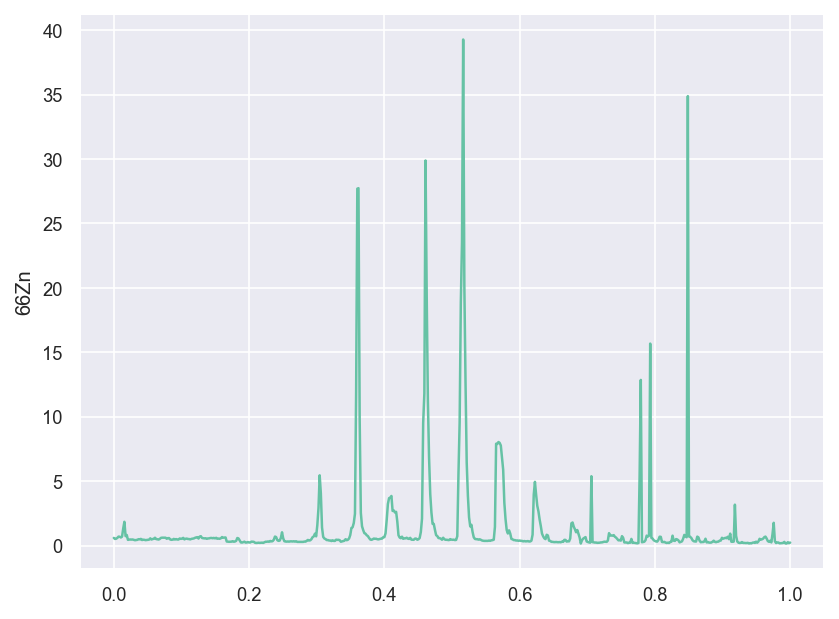

In [454]:
n_samples  = metal_df.shape[0]
linspace = np.linspace(0, 1, n_samples)

sns.lineplot(x=linspace, y="66Zn", data=metal_df)

# plot rpmE col
sns.lineplot(x=linspace, y="rpmE", data=prot_df, alpha=0.3)

# Join the metalloproteome data with the conversion table

In [315]:
# join the data
metal_join_df = metal_df.join(conversion_df, on="Experiment")

x_min = 2
y_min = 1

x_max = 15
y_max = 28


# filter out edges
# if x or y are 0, or x=17 or y=31, remove them.
metal_join_df = metal_join_df.filter((pl.col("x") >= x_min) & (pl.col("y") >= y_min) & (pl.col("x") <= x_max) & (pl.col("y") <=y_max))
prot_df = prot_df.filter((pl.col("x") >= x_min) & (pl.col("y") >= y_min) & (pl.col("x") <= x_max) & (pl.col("y") <= y_max))

metal_join_df

Experiment,27Al,47Ti,48Ti,51V,52Cr,55Mn,56Fe,57Fe,59Co,60Ni,63Cu,66Zn,75As,77Se,95Mo,111Cd,115In,118Sn,121Sb,182W,202Hg,208Pb,209Bi,x,y
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,i64
"""50to100_2""",1.088476,0.089522,0.527456,0.112932,0.397705,1.42577,2.549635,2.162723,0.032594,0.760848,0.228674,0.487249,0.008842,0.170408,0.073524,0.000432,-17.657278,0.035339,0.005507,12.119874,2.914968,0.005763,4.658133,2,1
"""50to100_3""",1.338329,0.089522,0.541534,0.10537,0.412184,1.406951,2.792358,2.548397,0.035764,0.799748,0.26995,0.52867,0.022738,0.068163,0.077422,0.001512,-18.038135,0.030184,0.00494,13.791576,2.290332,0.006253,4.81875,2,2
"""50to100_4""",1.414372,0.075387,0.568446,0.100767,0.434586,1.401477,3.098119,2.797819,0.035764,0.794059,0.288256,0.543672,0.018948,0.238571,0.077675,0.001512,-18.088951,0.032425,0.00575,14.000547,2.29033,0.006881,5.461254,2,3
"""50to100_5""",1.481725,0.08481,0.65581,0.101507,0.430873,1.401327,2.865319,2.632692,0.033781,0.78268,0.287251,0.560632,0.013895,0.204489,0.076844,0.001944,-17.959603,0.030632,0.006155,12.119879,2.498543,0.006935,4.336876,2,4
"""50to100_6""",1.386128,0.065963,0.712121,0.10011,0.420353,1.385657,2.85636,2.713523,0.034522,0.766536,0.27367,0.608903,0.015158,0.272652,0.076556,0.000864,-18.098247,0.025029,0.005264,14.836425,2.342384,0.006647,3.694374,2,5
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""700to800_25""",1.023242,0.076564,0.206102,0.107803,0.262816,0.119358,1.022619,0.776596,0.008429,0.220881,0.171453,0.253877,0.015781,0.132806,0.076556,0.001064,-15.137232,0.026768,0.004394,14.327084,1.753658,0.004305,4.039135,15,24
"""700to800_26""",1.035351,0.171144,0.192495,0.11267,0.273268,0.108888,1.00279,0.783095,0.008518,0.203661,0.162299,0.284162,0.013151,0.166008,0.071204,0.001064,-15.426602,0.02308,0.005127,16.28076,1.806798,0.003895,5.217219,15,25
"""700to800_27""",0.970767,0.040534,0.223312,0.112032,0.285041,0.073217,1.078176,0.767931,0.008215,0.188074,0.180037,0.240989,0.021041,0.166008,0.072764,0.000638,-15.283621,0.02249,0.004883,15.629534,2.072504,0.003905,6.563594,15,26


<Axes: ylabel='66Zn'>

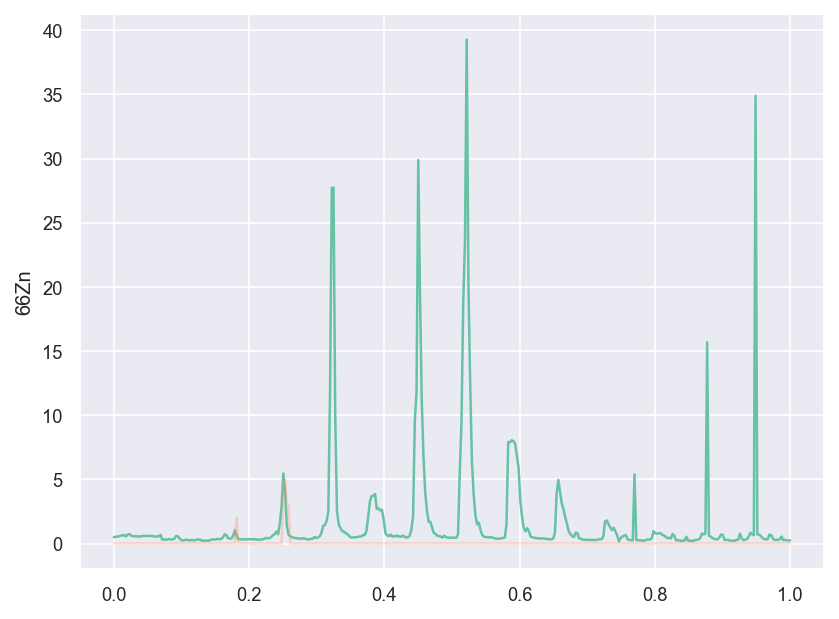

In [316]:
n_samples  = metal_join_df.shape[0]
linspace = np.linspace(0, 1, n_samples)

sns.lineplot(x=linspace, y="66Zn", data=metal_join_df)

# plot rpmE col
sns.lineplot(x=linspace, y="rpmE", data=prot_df, alpha=0.3)

# Import simulation data and conversion tables

In [455]:
# make protein-element mapping
elements = ["FE", "ZN", "MN", "CU", "MO", "NI"]
element_indices = [np.where(element_ids == element)[0][0] for element in elements]


# get name conversion table
gene_name_table = pl.read_csv("external_data/ecocyc_name_conversion.txt", separator="\t")

# rename cols to "Protein ID", "EcoCyc ID", "Accession Number", "Gene name"
gene_name_table.columns = ["Protein ID", "EcoCyc ID", "Accession Number", "Gene name"]

# get corresponding gene name for each protein
gene_name_table = gene_name_table.filter(pl.col("Protein ID").is_in(monomer_ids))

# make a mapping
gene_to_prot_dict = dict(zip(gene_name_table["Gene name"], gene_name_table["Protein ID"]))
prot_to_gene_dict = dict(zip(gene_name_table["Protein ID"], gene_name_table["Gene name"]))

# convert gene_names list to protein id list
detected_protein_ids = [gene_to_prot_dict[gene_name] for gene_name in gene_names if gene_name in gene_to_prot_dict]
# get indices of genes in gene dict
gene_indices = [gene_names.index(gene_name) for gene_name in gene_names if gene_name in gene_to_prot_dict]

# for each protein id, index it in the monomer_ids
detected_protein_idx = [monomer_ids.tolist().index(protein_id) for protein_id in detected_protein_ids]


In [456]:
monomer_to_complex_dict = {}

# create monomer to complex dict
for i, protein_id in enumerate(monomer_ids):
    if protein_id in monomer_ids:

        # get indices where C[:, i] is nonzero
        complex_indices = np.where(C[:, i].toarray() > 0)[0]

        # save complex_id if it doesn't match the protein_id
        complex_id = [protein_ids[idx] for idx in complex_indices if protein_ids[idx] != protein_id]

        # check in Tree if complex_id has parents by checking sum
        complex_parents = [Tree[:, tree_ids.index(complex_id)].sum() for complex_id in complex_id]

        # if complex_id doesn't have parents, select it
        for j, complex_id_idx in enumerate(complex_id):
            if complex_parents[j] == 0:
                monomer_to_complex_dict[protein_id] = complex_id[j]

                # if len(complex_id) > 1:
                    # print(f"Multiple complex ids found for protein: {protein_id}, complex ids: {complex_id}. Picked {complex_id[j]}")




In [457]:
elements = ["FE", "ZN", "MN", "CU", "MO", "NI"]
element_indices = [np.where(element_ids == element)[0][0] for element in elements]

sim_prot_metal = np.diag(total_counts_min.mean(axis=0) @ C) @ P @ E[:, element_indices]

# divide by col sums
sim_prot_metal = sim_prot_metal / sim_prot_metal.sum(axis=0)

sim_prot_metal_df = pl.DataFrame(sim_prot_metal, schema=elements)
sim_prot_metal_df = sim_prot_metal_df.with_columns(pl.Series(name="Protein ID", values=monomer_ids))
sim_prot_metal_df = sim_prot_metal_df.with_columns(pl.Series(name="Gene",
                                                             values=[prot_to_gene_dict[protein_id]  if protein_id in prot_to_gene_dict else "None" for protein_id in sim_prot_metal_df["Protein ID"]]))

# only include genes found in the experimental data
sim_prot_metal_df = sim_prot_metal_df.filter(pl.col("Gene").is_in(gene_names))

# use monomer_to_complex_dict to add complex id column by using polars replace
sim_prot_metal_df = sim_prot_metal_df.with_columns(pl.Series(name="Complex ID", values=sim_prot_metal_df["Protein ID"].replace(monomer_to_complex_dict)))


sim_prot_metal_df

FE,ZN,MN,CU,MO,NI,Protein ID,Gene,Complex ID
f64,f64,f64,f64,f64,f64,str,str,str
0.0,0.0,0.0,0.0,0.0,0.0,"""1-PFK-MONOMER""","""fruK""","""1-PFK"""
0.0,0.0,0.0,0.0,0.0,0.0,"""2-ISOPROPYLMALATESYN-MONOMER""","""leuA""","""2-ISOPROPYLMALATESYN-MONOMER"""
0.0,0.0,0.0,0.0,0.0,0.0,"""2-OCTAPRENYL-METHOXY-BENZOQ-ME…","""ubiE""","""CPLX0-8301"""
0.0,0.0,0.0,0.0,0.0,0.0,"""3-CH3-2-OXOBUTANOATE-OH-CH3-XF…","""panB""","""3-METHYL-2-OXOBUT-OHCH3XFER-CP…"
0.0,0.0,0.0,0.0,0.0,0.0,"""3-ISOPROPYLMALDEHYDROG-MONOMER""","""leuB""","""3-ISOPROPYLMALDEHYDROG-CPLX"""
…,…,…,…,…,…,…,…,…
0.0,0.0,0.0,0.0,0.0,0.0,"""YJJK-MONOMER""","""ettA""","""YJJK-MONOMER"""
0.0,0.0,0.0,0.0,0.0,0.0,"""YLIB-MONOMER""","""gsiB""","""ABC-49-CPLX"""
0.0,0.0,0.0,0.0,0.0,0.0,"""YNEA-MONOMER""","""lsrB""","""ABC-58-CPLX"""


# Plot unprocessed data

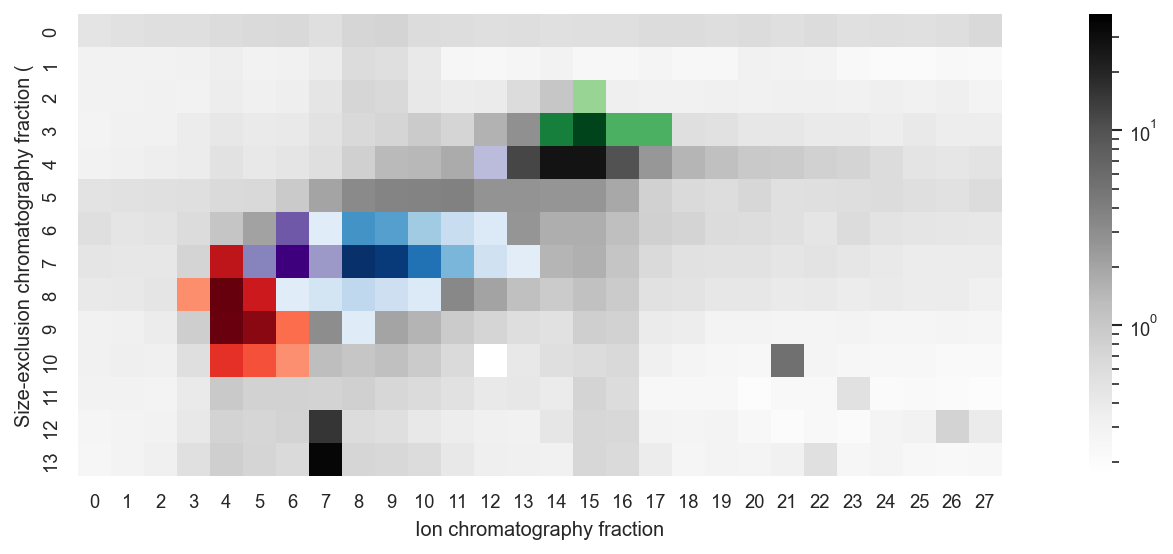

In [458]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(15, 4))

# heatmap of 56Fe data against x and y
sns.heatmap(metal_join_df.pivot("66Zn", "x", "y", )[:, 1:], cmap="Grays", square=True, cbar=True, norm=LogNorm())
sns.heatmap(prot_df.pivot("metE", "x", "y", )[:, 1:], mask=(prot_df.pivot("metE", "x", "y", ) < 50).to_numpy()[:, 1:], 
            cmap="Blues", square=True, cbar=False, vmin=0)
sns.heatmap(prot_df.pivot("rpmE", "x", "y", )[:, 1:], mask=(prot_df.pivot("rpmE", "x", "y", ) < 1).to_numpy()[:, 1:], 
            cmap="Greens", square=True, vmin=0, cbar=False)
sns.heatmap(prot_df.pivot("rpoC", "x", "y", )[:, 1:], mask=(prot_df.pivot("rpoC", "x", "y", ) < 100).to_numpy()[:, 1:], 
            cmap="Reds", square=True, vmin=0, cbar=False)
sns.heatmap(prot_df.pivot("pyrI", "x", "y", )[:, 1:], mask=(prot_df.pivot("pyrI", "x", "y", ) < 80).to_numpy()[:, 1:], 
            cmap="Purples", square=True, vmin=0, cbar=False)

# change x and y axis labels
plt.ylabel("Size-exclusion chromatography fraction (")
plt.xlabel("Ion chromatography fraction")

# make xticklabels and yticklabels start from x_min and y_min and end at x_max and y_max

# set xticklabels
# plt.xticks(np.arange(y_min, y_max, 1) - 0.5, np.arange(y_min, y_max, 1))
# plt.yticks(np.arange(x_min, x_max, 1) - 0.5, np.arange(x_min, x_max, 1))

# save as png and svg
plt.savefig("figures/metal_splashes.png")
plt.savefig("figures/metal_splashes.svg")


# Plot grid of heatmaps

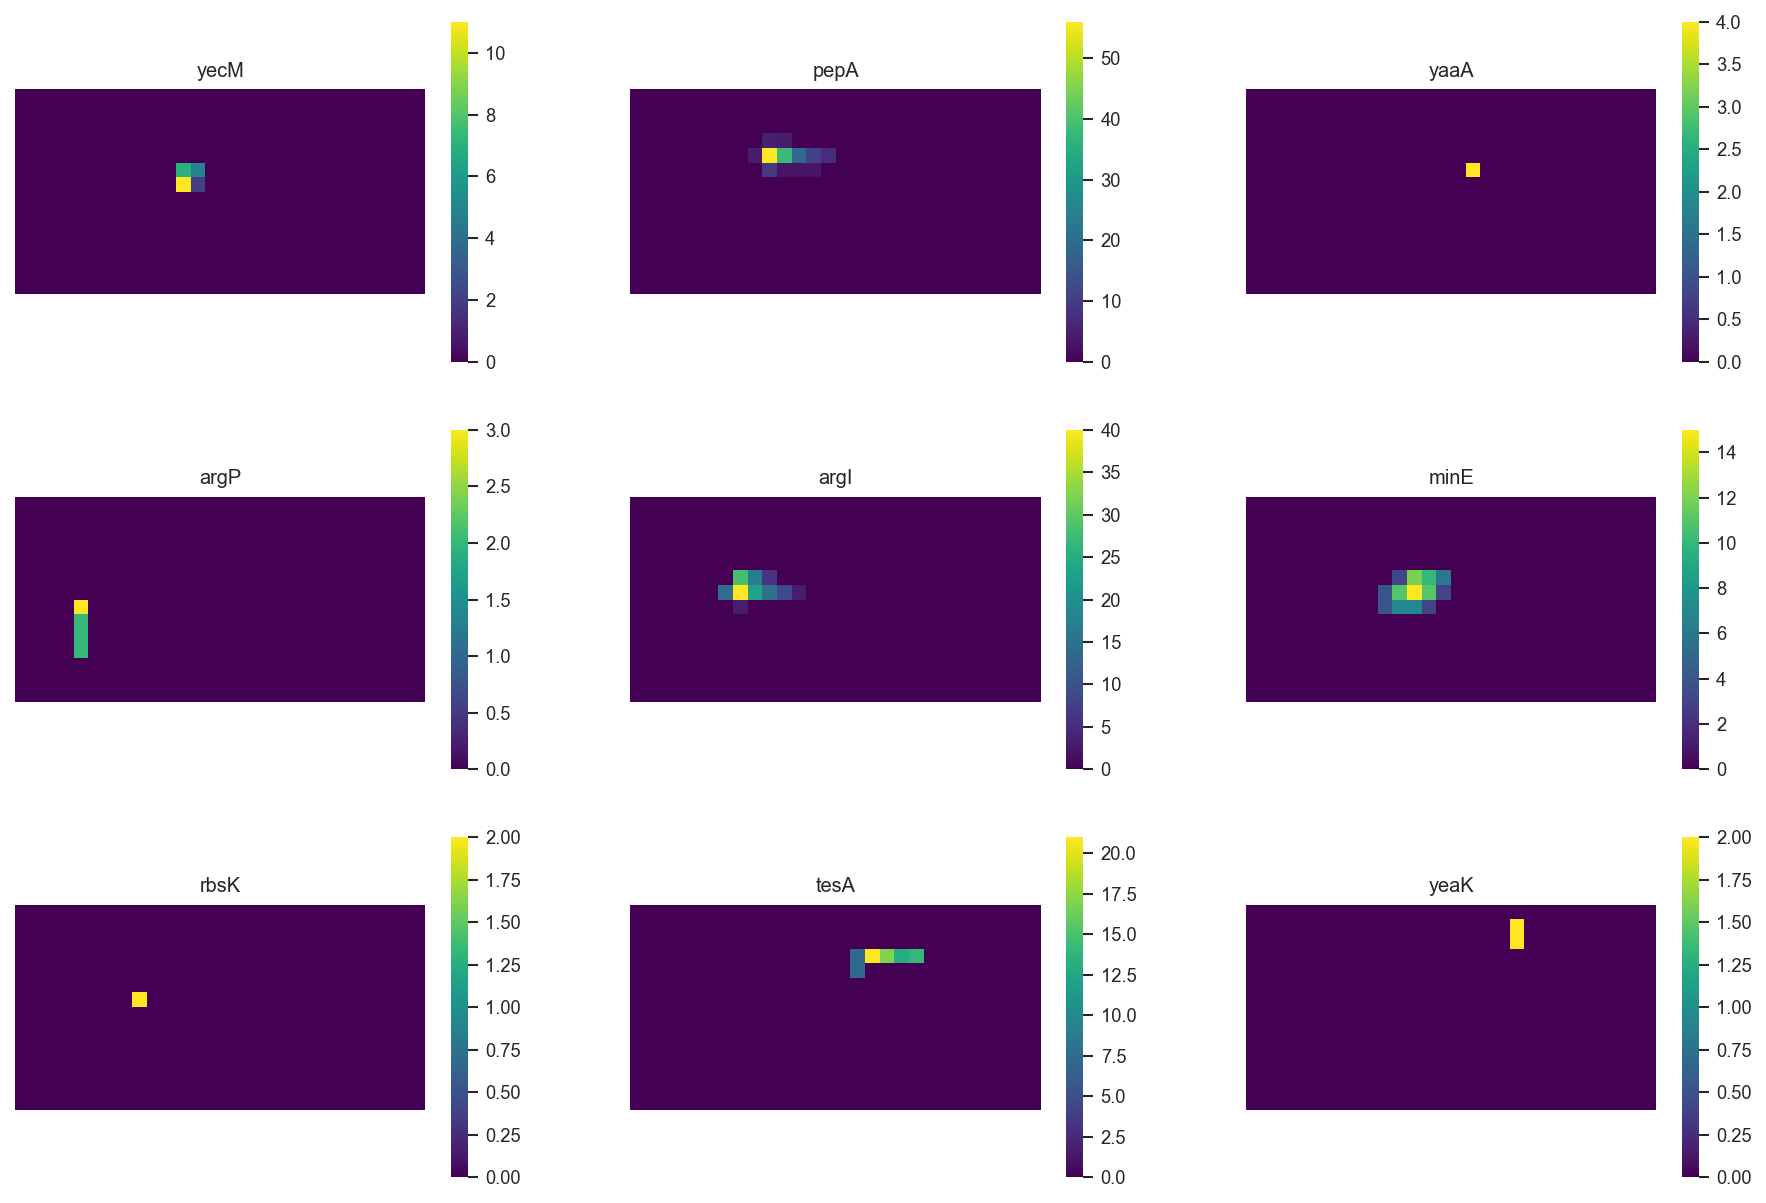

In [459]:
# for 9 random proteins, plot a grid of small heatmaps
random_proteins = np.random.choice(gene_names, 9)

fig, axs = plt.subplots(3, 3, figsize=(15, 10))
for i, ax in enumerate(axs.flatten()):
    sns.heatmap(prot_df.pivot(random_proteins[i], "x", "y", )[:, 1:], cmap="viridis", square=True, cbar=True, ax=ax)
    ax.set_title(random_proteins[i])
    ax.set_xticks([])
    ax.set_yticks([])

    ## Filter out edges

In [460]:
# For each protein, pivot and do some filtering

for protein in gene_names:
    prot_pivot = prot_df.pivot(protein, "x", "y", ).to_numpy()[:, 1:]

    # create boolean array
    prot_mask = prot_pivot > 0

    # find number of neighbours per well
    footprint = np.array([[1,1,1],
                          [1,0,1],
                          [1,1,1]])

    f = lambda x: x.sum()

    results = ndimage.generic_filter(prot_mask, f, footprint=footprint, mode="constant", cval=0)

    # get AND of the two
    prot_pivot_true_mask = prot_mask & results

    # dont zero if it would remove all the data
    if prot_pivot_true_mask.sum() > 0:
        prot_pivot[~prot_pivot_true_mask] = 0

    # set column as flattened pivot
    prot_df = prot_df.with_columns(pl.Series(name=protein, values=prot_pivot.flatten()))



In [467]:
# for specific wells, zero all metal masses.
problem_wells = [[12, 7], [13, 7], [10, 21]]

# loop through metal cols, pivot, and zero out the problem wells
for metal in metals:
    metal_pivot = metal_join_df.pivot(metal, "x", "y", ).to_numpy()[:, 1:]

    # set to minimum value
    for well in problem_wells:
        metal_pivot[well[0], well[1]] = np.median(metal_pivot)

    # set column as flattened pivot
    metal_join_df = metal_join_df.with_columns(pl.Series(name=metal, values=metal_pivot.flatten()))


In [468]:
metal_join_df.pivot("66Zn", "x", "y", )[:, 1:][10, 21]

0.5172253844655784

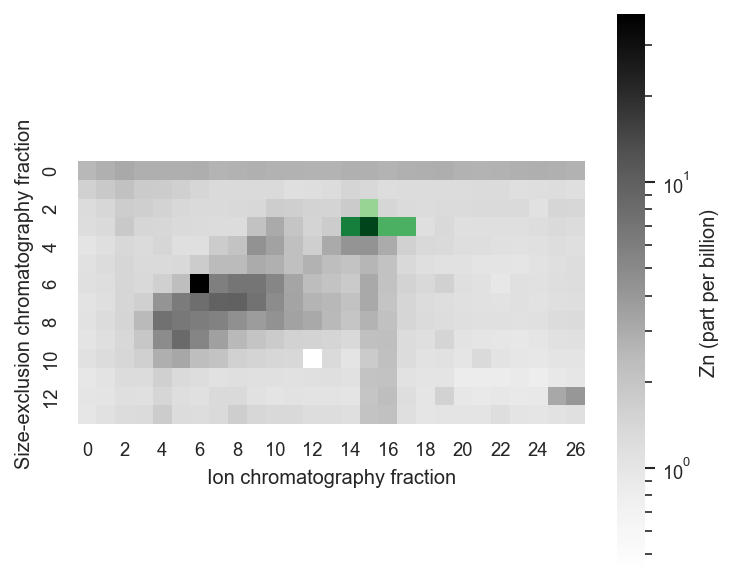

In [469]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(5, 4))

# heatmap of 56Fe data against x and y
sns.heatmap(metal_join_df.pivot("56Fe", "x", "y", )[:, 1:], cmap="Grays", square=True, cbar=True, norm=LogNorm(), cbar_kws={'label': 'Zn (part per billion)'})
sns.heatmap(prot_df.pivot("rpmE", "x", "y", )[:, 1:], mask=(prot_df.pivot("rpmE", "x", "y", ) < 1).to_numpy()[:, 1:],
            cmap="Greens", square=True, cbar=False, vmin=0,  cbar_kws={'label': 'RpmE (spectral count)'})

# change x and y axis labels
plt.ylabel("Size-exclusion chromatography fraction")
plt.xlabel("Ion chromatography fraction")

plt.xlim([0, 27])
plt.ylim([14,0])

plt.tight_layout()

# save as png and svg
# plt.savefig("figures/zn_rpme.png")
# plt.savefig("figures/zn_rpme.svg")


# Check out some data

In [470]:
prot_df.filter((pl.col("y") == 7) & (pl.col("x") == 13)).melt(id_vars=["Experiment", "x", "y"], variable_name="Gene", value_name="Intensity")

Experiment,x,y,Gene,Intensity
str,i64,i64,str,i64
"""600to650_8""",13,7,"""tufB""",44
"""600to650_8""",13,7,"""rplC""",8
"""600to650_8""",13,7,"""rpsE""",18
"""600to650_8""",13,7,"""fliC""",37
"""600to650_8""",13,7,"""groL""",55
…,…,…,…,…
"""600to650_8""",13,7,"""ygaC""",0
"""600to650_8""",13,7,"""ycaK""",0
"""600to650_8""",13,7,"""miaA""",0


<Figure size 1500x750 with 0 Axes>

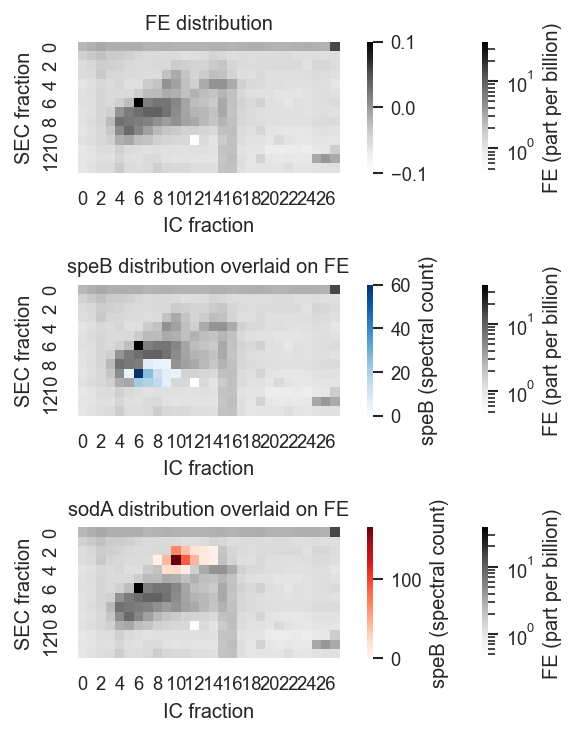

In [471]:
from matplotlib.colors import LogNorm
plt.figure(figsize=(10, 5))

f, ax = plt.subplots(3,1, figsize=(5, 5))

gene = "speB"
gene2 = "sodA"
metal = "56Fe"
metal_translated = isotope_element_mapping[metal]

# heatmap of 56Fe data against x and y
sns.heatmap(metal_join_df.pivot(metal, "x", "y", )[:, 1:], cmap="Grays", square=True, cbar=True,
            norm=LogNorm(), cbar_kws={'label': f'{metal_translated} (part per billion)'}, ax=ax[0])
sns.heatmap(prot_df.pivot(gene, "x", "y", )[:, 1:], mask=(prot_df.pivot(gene, "x", "y", ) < 100).to_numpy()[:, 1:],
            cmap="Grays", square=True, cbar=True, vmin=0,  cbar_kws={'label': f' '}, ax=ax[0])

# add x and y labels
ax[0].set_ylabel("SEC fraction")
ax[0].set_xlabel("IC fraction")


sns.heatmap(metal_join_df.pivot(metal, "x", "y", )[:, 1:], cmap="Grays", square=True,
            cbar=True, norm=LogNorm(), cbar_kws={'label': f'{metal_translated} (part per billion)'}, ax=ax[1])
sns.heatmap(prot_df.pivot(gene, "x", "y", )[:, 1:], mask=(prot_df.pivot(gene, "x", "y", ) < 1).to_numpy()[:, 1:],
            cmap="Blues", square=True, cbar=True, vmin=0,  cbar_kws={'label': f'{gene} (spectral count)'}, ax=ax[1])

# add x and y labels
ax[1].set_ylabel("SEC fraction")
ax[1].set_xlabel("IC fraction")

sns.heatmap(metal_join_df.pivot(metal, "x", "y", )[:, 1:], cmap="Grays", square=True,
            cbar=True, norm=LogNorm(), cbar_kws={'label': f'{metal_translated} (part per billion)'}, ax=ax[2])
sns.heatmap(prot_df.pivot(gene2, "x", "y", )[:, 1:], mask=(prot_df.pivot(gene2, "x", "y", ) < 1).to_numpy()[:, 1:],
            cmap="Reds", square=True, cbar=True, vmin=0,  cbar_kws={'label': f'{gene} (spectral count)'}, ax=ax[2])

# add x and y labels
ax[2].set_ylabel("SEC fraction")
ax[2].set_xlabel("IC fraction")

# add subplot titles
ax[0].set_title(f"{metal_translated} distribution")
ax[1].set_title(f"{gene} distribution overlaid on {metal_translated}")
ax[2].set_title(f"{gene2} distribution overlaid on {metal_translated}")

plt.tight_layout()

# save as png and svg
plt.savefig("figures/cu.png")
# plt.savefig("figures/zn_bare.svg")


# Identify protein responsible for unknown peak

In [472]:
description_df = prot_df_raw.select(["Identified Proteins (1235)", "Accession Number"])

description_df = gene_df.join(description_df, on="Accession Number")

# rename Identified Proteins (1235) to "Description"
description_df = description_df.rename({"Identified Proteins (1235)": "Description", "Gene Name": "Gene"})

# Add new column, "is unknown function", 
description_df = description_df.with_columns(pl.Series(name="is unknown function", values=[1 if desc.startswith("y") else 0 for desc in description_df["Gene"]]))

description_df.filter(pl.col("is unknown function") == 1)

Accession Number,Gene,Description,is unknown function
str,str,str,i64
"""AAC74534.1""","""yncE""","""ATP-binding protein, periplasm…",1
"""AAC74287.1""","""ychF""","""catalase inhibitor protein; AT…",1
"""AAC74934.1""","""yebC""","""UPF0082 family protein [Escher…",1
"""AAC74850.2""","""yeaD""","""D-hexose-6-phosphate epimerase…",1
"""AAC76668.1""","""yicC""","""UPF0701 family protein [Escher…",1
…,…,…,…
"""AAC74609.1""","""ydeI""","""hydrogen peroxide resistance O…",1
"""AAC74504.2""","""ydcI""","""putative DNA-binding transcrip…",1
"""AAC74995.1""","""yedD""","""lipoprotein [Escherichia coli …",1


# Pre

# Matrix/optimization approach.

In [473]:

# compute the timeseries for the elements
PE = P @ E[:, element_indices]

# get the PE matrix for the detected proteins
PE_detected = PE[detected_protein_idx, :]

PE_detected

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 137 stored elements and shape (1228, 6)>

In [519]:
cur_metal = "FE"

# find complexes with metal
cplx_has_metal = sim_prot_metal_df.group_by("Complex ID").agg(pl.sum(cur_metal))

# rename metal col to "Complex has metal"
cplx_has_metal = cplx_has_metal.rename({cur_metal: "Complex has metal"})

# convert to boolean
cplx_has_metal = cplx_has_metal.with_columns(pl.Series(name="Complex has metal", values=cplx_has_metal["Complex has metal"] > 0))

# join
sim_metal_spec = sim_prot_metal_df.join(cplx_has_metal, on="Complex ID")

# filter to only include detected proteins
sim_metal_spec = sim_metal_spec.filter(pl.col("Protein ID").is_in(detected_protein_ids))

sim_metal_spec

FE,ZN,MN,CU,MO,NI,Protein ID,Gene,Complex ID,Complex has metal
f64,f64,f64,f64,f64,f64,str,str,str,bool
0.0,0.0,0.0,0.0,0.0,0.0,"""1-PFK-MONOMER""","""fruK""","""1-PFK""",false
0.0,0.0,0.0,0.0,0.0,0.0,"""2-ISOPROPYLMALATESYN-MONOMER""","""leuA""","""2-ISOPROPYLMALATESYN-MONOMER""",false
0.0,0.0,0.0,0.0,0.0,0.0,"""2-OCTAPRENYL-METHOXY-BENZOQ-ME…","""ubiE""","""CPLX0-8301""",false
0.0,0.0,0.0,0.0,0.0,0.0,"""3-CH3-2-OXOBUTANOATE-OH-CH3-XF…","""panB""","""3-METHYL-2-OXOBUT-OHCH3XFER-CP…",false
0.0,0.0,0.0,0.0,0.0,0.0,"""3-ISOPROPYLMALDEHYDROG-MONOMER""","""leuB""","""3-ISOPROPYLMALDEHYDROG-CPLX""",false
…,…,…,…,…,…,…,…,…,…
0.0,0.0,0.0,0.0,0.0,0.0,"""YJJK-MONOMER""","""ettA""","""YJJK-MONOMER""",false
0.0,0.0,0.0,0.0,0.0,0.0,"""YLIB-MONOMER""","""gsiB""","""ABC-49-CPLX""",false
0.0,0.0,0.0,0.0,0.0,0.0,"""YNEA-MONOMER""","""lsrB""","""ABC-58-CPLX""",false


In [520]:
prof_df_gene_order = prot_df.drop(["Experiment", "x", "y"]).columns

# only pick out the genes that are in the gene_indices
prot_df_gene_order = [gene for gene in prof_df_gene_order if gene in gene_to_prot_dict]

M = prot_df.drop(["Experiment", "x", "y"]).to_numpy()[:, gene_indices]

# for each gene in prot_df_gene_order, pick out the corresponding index in sim_metal_spec
# and get the "Complex has metal" value
m_filter = np.zeros(len(detected_protein_ids))

for i, gene in enumerate(prot_df_gene_order):
    if gene in sim_metal_spec["Gene"]:
        m_filter[i] = sim_metal_spec.filter(pl.col("Gene") == gene).select("Complex has metal").to_numpy()[0,0]

m_filter

array([0., 0., 0., ..., 0., 0., 0.])

In [521]:
# n_well x n_prot matrix of normalized intensities
# n_well x 1 vector of metal masses 
# n_prot x 1 vector of protein counts (variable) times per protein stoichiometry

M = prot_df.drop(["Experiment", "x", "y"]).to_numpy()[:, gene_indices]

gene_names_filtered = np.array(gene_names)[gene_indices].tolist()

# set dtype to float64
M = M.astype(np.float64)

# change nans to 0
M[np.isnan(M)] = 0

# normalize the matrix so each col sums to 1
col_sums = M.sum(axis=0)
M = M / col_sums

# change nans to 0
M[np.isnan(M)] = 0

# get the Zn vector
m_vec = metal_join_df[element_isotope_mapping[cur_metal]].to_numpy()

# normalize m_vec
m_vec = m_vec / m_vec.sum()

# get the filter for proteins that have Zn
element_idx = elements.index(cur_metal)
# m_filter = PE_detected[:, element_idx].toarray().flatten()

In [522]:
n_cplx_filt = sim_metal_spec.unique("Complex ID").shape[0]
cplx_names_mix = sim_metal_spec.unique("Complex ID").select("Complex ID").to_numpy()[:,0].tolist()

# create a monomer to complex matrix for comparing to sim
C_mixed = np.zeros([n_cplx_filt, len(gene_names_filtered)])

# for each gene, find the corresponding complex id in sim_metal_spec
for i, gene in enumerate(gene_names_filtered):
    cplx_id = sim_metal_spec.filter(pl.col("Gene") == gene).select("Complex ID").to_numpy()[0,0]
    cplx_idx = cplx_names_mix.index(cplx_id)
    
    C_mixed[cplx_idx, i] = 1

In [523]:
sim_cplx_met_agg = sim_metal_spec.group_by("Complex ID").agg(pl.sum(cur_metal))

sim_cplx_met_agg.sort(cur_metal)

# create target vec
cplx_agg_vec = np.zeros(n_cplx_filt)

# for each complex, find the corresponding index in sim_metal_spec, set the value to the Zn value
for i, cplx_id in enumerate(cplx_names_mix):
    cplx_agg_vec[i] = sim_cplx_met_agg.filter(pl.col("Complex ID") == cplx_id).select(cur_metal).to_numpy()[0,0]

In [524]:
counts = cp.Variable(len(detected_protein_ids))

# create the constraints
constr = []
constr.append(counts >= 0)

obj = cp.norm1( M @ cp.multiply(counts, m_filter) - m_vec) 
obj += 1 * cp.norm2(C_mixed @ counts - cplx_agg_vec) 
obj += 0.000001 * cp.sum(counts)

prob = cp.Problem(cp.Minimize(obj), constr,)
prob.solve( solver="CLARABEL")

counts_solved = counts.value

In [525]:
np.abs( M @ np.multiply(counts.value, m_filter) - m_vec ).sum()

0.6943294305269827

In [526]:
np.abs( M @ np.multiply(counts.value, m_filter) - m_vec ).sum()

0.6943294305269827

In [527]:
gene_responsible_mass =  (M @ np.diag(np.multiply(counts.value, m_filter))).sum(axis=0)
# note that this will not be 1, since some metal mass is not accounted for because no protein is available. 

# normalize
gene_responsible_mass_norm = gene_responsible_mass / gene_responsible_mass.sum()

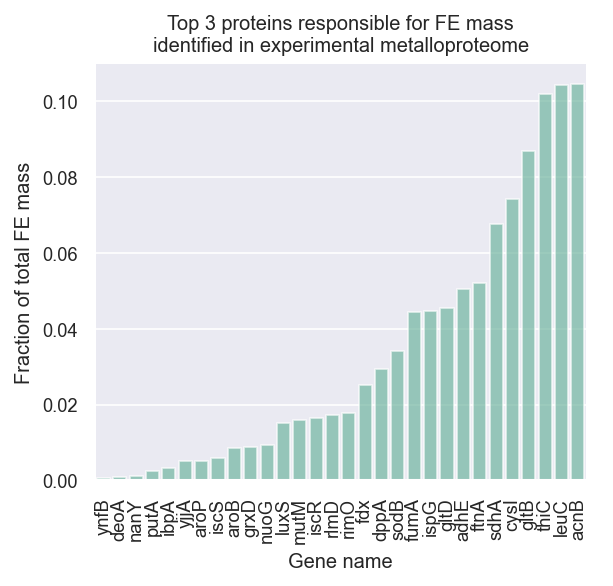

In [528]:
# argsort the counts and plot
sorted_counts = np.argsort(counts_solved)
sorted_mass = np.argsort(gene_responsible_mass_norm)

# plot the counts
sns.catplot(x=np.array(gene_names)[sorted_mass[-30:]], y=gene_responsible_mass_norm[sorted_mass[-30:]], kind="bar", aspect=1, alpha=0.7, height=4)

# rotate labels
plt.xticks(rotation=90)

# add xlabel
plt.xlabel("Gene name")
plt.ylabel(f"Fraction of total {cur_metal} mass")
plt.title(f"Top 3 proteins responsible for {cur_metal} mass\nidentified in experimental metalloproteome")

plt.tight_layout()

# save as png and svg
plt.savefig("figures/mn_mass.png")
plt.savefig("figures/mn_mass.svg")

# Compare to simulation

In [541]:
# create complex assignments
exp_cplx_met_assign = C_mixed @ counts_solved

# normalize by sum
exp_cplx_met_assign = exp_cplx_met_assign  # / exp_cplx_met_assign.sum()

# create a dataframe
exp_cplx_met_df = pl.DataFrame(exp_cplx_met_assign, schema=["Mass"])

# add complex id
exp_cplx_met_df = exp_cplx_met_df.with_columns(pl.Series(name="Complex ID", values=cplx_names_mix))

# join with sim_metal_spec
exp_cplx_met_df = exp_cplx_met_df.join(sim_cplx_met_agg.select(["Complex ID", cur_metal]), on="Complex ID")

# filter out rows where ZN is 0
exp_cplx_met_df = exp_cplx_met_df.filter((pl.col(cur_metal) > 0) & (pl.col("Mass") > 0))

exp_cplx_met_df.to_pandas()

,Mass,Complex ID,FE
0,2.550331e-10,HYDROPEROXIDI-CPLX,0.003073
1,3.493553e-03,NADH-DHI-CPLX,0.021851
2,2.727634e-02,SULFITE-REDUCT-CPLX,0.019014
3,2.138756e-03,CPLX0-248,0.020700
4,2.489810e-02,CPLX0-8160,0.064762
5,2.817086e-04,CPLX0-7760,0.002081
6,1.301304e-09,G7266-MONOMER,0.002951
7,1.067722e-09,CPLX0-7564,0.014397
8,3.840261e-02,3-ISOPROPYLMALISOM-CPLX,0.049113
9,1.915374e-02,CPLX0-3969,0.023653


In [542]:
rib_genes

['rplA',
 'rplB',
 'rplC',
 'rplD',
 'rplE',
 'rplF',
 'rplI',
 'rplJ',
 'rplK',
 'rplL',
 'rplM',
 'rplN',
 'rplO',
 'rplP',
 'rplQ',
 'rplR',
 'rplS',
 'rplT',
 'rplV',
 'rplW',
 'rplX',
 'rplY',
 'rpmB',
 'rpmC',
 'rpmD',
 'rpmE',
 'rpmG',
 'rpmH',
 'rpsA',
 'rpsB',
 'rpsC',
 'rpsD',
 'rpsE',
 'rpsF',
 'rpsG',
 'rpsH',
 'rpsI',
 'rpsJ',
 'rpsK',
 'rpsL',
 'rpsM',
 'rpsN',
 'rpsP',
 'rpsQ',
 'rpsR',
 'rpsS',
 'rpsT',
 'rpsU',
 'rpmJ',
 'rplU',
 'rpmA']

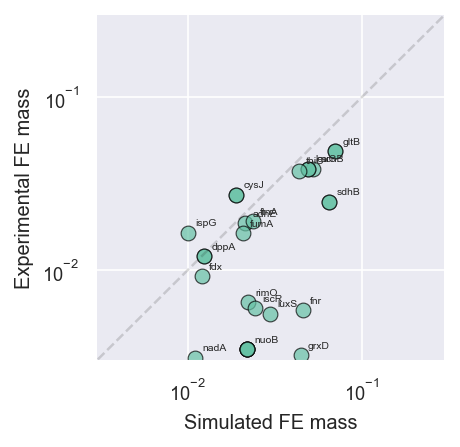

In [543]:
# plot
plt.figure(figsize=(3, 3))

cplx_gene_conversion = sim_metal_spec.select(["Complex ID", "Gene"]) 

# get all genes that have ribosome as cplx
rib_genes = cplx_gene_conversion.filter(pl.col("Complex ID") == "CPLX0-3964").select("Gene").to_numpy()[:,0].tolist()
# create mapping
rib_gene_mapping = {gene: "Ribosome" for gene in rib_genes}

# if Complex ID is CPLX0-3964, change gene to ribosome
cplx_gene_conversion = cplx_gene_conversion.with_columns(pl.Series(name="Gene", values=cplx_gene_conversion["Gene"].replace(rib_gene_mapping)))

# join with exp_cplx_met_df
exp_cplx_met_plot_df = exp_cplx_met_df.join(cplx_gene_conversion, on="Complex ID")

sns.scatterplot(x=cur_metal, y="Mass", data=exp_cplx_met_plot_df, alpha=0.7, s=50, edgecolor="black")

# add log scale

plt.xscale("log")
plt.yscale("log")

# limit x and y from 1e-3 to 1e0
plt.xlim([3e-3, 3e-1])
plt.ylim([3e-3, 3e-1])

# change x and y labels
plt.xlabel(f"Simulated {cur_metal} mass")
plt.ylabel(f"Experimental {cur_metal} mass")


cplx_already_added = []
# below each point, plot the name of the protein
for i, txt in enumerate(exp_cplx_met_plot_df["Gene"].to_numpy()):
    cur_cplx = exp_cplx_met_plot_df["Complex ID"].to_numpy()[i]
    
    if cur_cplx not in cplx_already_added:
        plt.annotate(txt, (exp_cplx_met_plot_df[cur_metal].to_numpy()[i] * 1.1, exp_cplx_met_plot_df["Mass"].to_numpy()[i] * 1.1), fontsize=5)
    
    cplx_already_added.append(cur_cplx)
    

# add x=y line
plt.plot([1e-3, 3e-1], [1e-3, 3e-1], color="black", linestyle="--", alpha=0.15)

# Test a loop 

In [532]:
# try running loop to see how the objective changes
reg_values = np.logspace(-8, 1, 30)

obj_values = np.zeros(len(reg_values))
sim_values = np.zeros(len(reg_values))

for i, reg in enumerate(reg_values):
    obj = cp.norm1( M @ cp.multiply(counts, m_filter) - m_vec) 
    obj += reg * cp.norm2(C_mixed @ counts - cplx_agg_vec) 
    obj += 0.000001 * cp.sum(counts)

    prob = cp.Problem(cp.Minimize(obj), constr,)
    prob.solve( solver="CLARABEL")

    obj_values[i] = np.abs( M @ np.multiply(counts.value, m_filter) - m_vec ).sum()
    sim_values[i] = np.abs( C_mixed @ counts.value - cplx_agg_vec ).sum()
    
obj_values

array([0.67687096, 0.67687096, 0.67687096, 0.67687096, 0.67687096,
       0.67687096, 0.67687096, 0.67687096, 0.67687096, 0.67687096,
       0.67687096, 0.67687096, 0.67687096, 0.67687096, 0.67687096,
       0.67687096, 0.67687096, 0.67687096, 0.67687096, 0.67687096,
       0.67687229, 0.67687412, 0.67726848, 0.67772337, 0.68009438,
       0.68649953, 0.69965578, 0.72879478, 0.93574821, 1.04957199])

(0.0, 1.0)

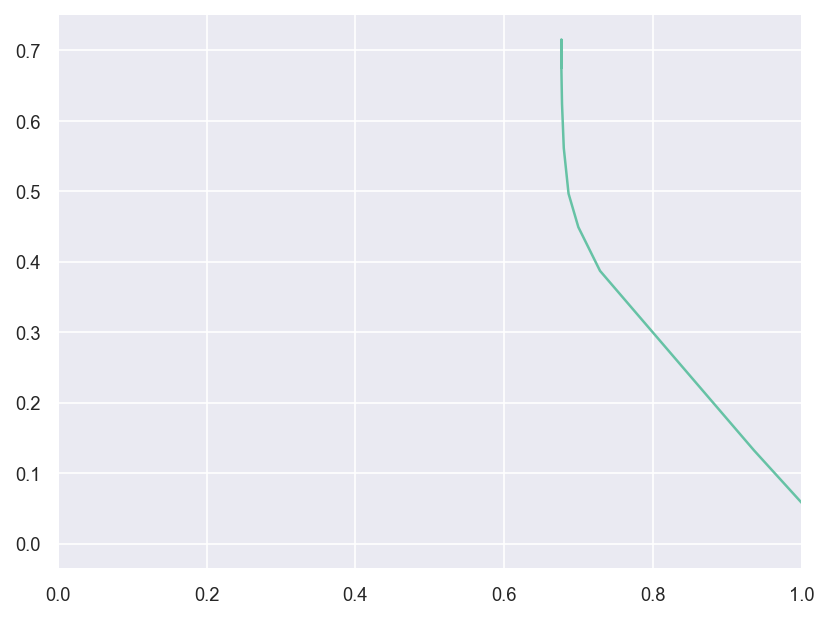

In [534]:
# plot the objective values
plt.plot(obj_values, sim_values)

# make x go from 0 to 0.6
plt.xlim([0, 1])

# x scale log